<a href="https://colab.research.google.com/github/aformen9/BC-ML-Project/blob/agu/notebook/BreastCancer_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explicacion teoria
Para este caso de clasificación de tumores (M vs. B) sobre el dataset de Breast Cancer Wisconsin, te recomendaría emplear Regresión Logística y Random Forest. A continuación, un breve razonamiento de por qué estos dos modelos cumplen bien los requisitos del trabajo:

### Regresión Logística

- Ventajas:

Es un modelo lineal sencillo y muy interpretativo: puedes ver directamente el peso que asigna a cada variable (coeficientes), lo cual ayuda a explicar el resultado en lenguaje comprensible para un público no experto.

Suele servir como “baseline” (modelo base) para cualquier tarea de clasificación binaria; si su desempeño es razonable, sabrás que el problema no es extremadamente complejo.

Su entrenamiento es rápido y, al ser lineal, no requiere tanto ajuste de hiperparámetros.

- Aplicación en este dataset:

Permite ver claramente qué características (por ejemplo, el radio medio, la textura media, el área, etc.) tienden a asociarse más con tumores malignos o benignos.

Al graficar la matriz de confusión, podrás ver cuántos casos de cáncer benigno se clasifican correctamente (TN), cuántos falsos negativos (FN), etc., y explicarlo de forma sencilla: “de cada 100 tumores malignos, el modelo detectó X correctamente y falló en Y”.

###Random Forest

- Ventajas:

Es un ensamble de árboles de decisión que combina múltiples “árboles débiles” para obtener un clasificador robusto, capaz de capturar relaciones no lineales y jerarquías complejas entre variables.

Maneja bien la multicolinealidad y las características con diferentes escalas, y suele dar muy buena precisión en problemas de detección de enfermedades.

Permite obtener la importancia de cada variable (feature importance), lo que facilita justificar por qué ciertas medidas celulares (p. ej., concavidad o suavidad) son más relevantes para predecir malignidad.

- Aplicación en este dataset:

Podrás comparar su desempeño (accuracy, recall, precision, AUC) contra la Regresión Logística. Generalmente Random Forest supera al modelo lineal si hay interacciones o patrones complejos entre las características.

Al graficar la matriz de confusión para Random Forest, mostrarás cuántos tumores malignos detectó correctamente frente a cuántos clasificó erróneamente. Además, puedes incluir un mapa de calor de correlaciones o un boxplot/violin para justificar por qué ciertos grupos de variables (por ejemplo, medidas de perímetro o área) son marcadores fuertes y cómo Random Forest las aprovecha.

###¿Por qué no elijo Decision Tree como segundo modelo?
- Árbol de Decisión simple:

Aunque es muy interpretable y visual (puedes dibujar el árbol completo), tiende a sobreajustarse con facilidad, sobre todo en datasets con muchas variables numéricas y ruido, como este.

Al incluir Random Forest en lugar de un único árbol, te aseguras de “proteger” esa interpretación de árboles simples contra el sobreajuste, ya que el ensamble promedia múltiples árboles.

Sin embargo, podrías usar Decision Tree como experimento adicional (pues el enunciado lo permite), pero para el entregable final te alcanzan dos modelos: uno lineal (Regresión Logística) y uno no lineal/ensemble (Random Forest).

# Exploracion del dataset

In [4]:
!git clone https://github.com/aformen9/BC-ML-Project.git
%cd BC-ML-Project

Cloning into 'BC-ML-Project'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 77.42 KiB | 1.52 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/BC-ML-Project/BC-ML-Project


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
cancer_data = pd.read_csv('/content/BC-ML-Project/data/Breast Cancer Wisconsin_TF.csv')
cancer_data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [22]:
# Dimesiones del df; filas y coluknas:
cancer_data.shape

(569, 33)

In [23]:
# Tipo de dato de cada columna:
cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              552 non-null    float64
 3   texture_mean             541 non-null    float64
 4   perimeter_mean           513 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [40]:
# Cantidad de valores nulos en el df:
print(f"\nValores nulos por columna:\n \n{cancer_data.isnull().sum()}")


Valores nulos por columna:
 
id                           0
diagnosis                    0
radius_mean                 17
texture_mean                28
perimeter_mean              56
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_d

In [8]:
# Estadisticas descriptivas:
cancer_data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,552.000000,541.000000,513.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.130813,19.314529,91.620351,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.536453,4.329154,24.206004,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.687500,16.180000,74.720000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.415000,18.890000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.797500,21.810000,103.700000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [18]:
# Cantidad total de pacientes analizados:
total_pacientes = len(cancer_data)
print(f"Pacientes totales: {total_pacientes}")

Pacientes totales: 569


In [32]:
# Cantidad de tumeros benignos (B) y malignos (M)
print(cancer_data['diagnosis'].value_counts())
# % de pacientes con tumores benignos y malignos:
porcentaje_B = (357 * 100) / 569
porcentaje_M = (212 * 100) / 569
print(f"Porcentaje de pacientes con tumores benignos: {porcentaje_B:.2f}%")
print(f"Porcentaje de pacientes con tumores malignos: {porcentaje_M:.2f}%")

diagnosis
B    357
M    212
Name: count, dtype: int64
Porcentaje de pacientes con tumores benignos: 62.74%
Porcentaje de pacientes con tumores malignos: 37.26%


In [41]:
# Tipos de datos:
data_type = cancer_data.dtypes
print(f"Tipos de datos por columnas:\n \n{data_type}")

Tipos de datos por columnas:
 
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst       

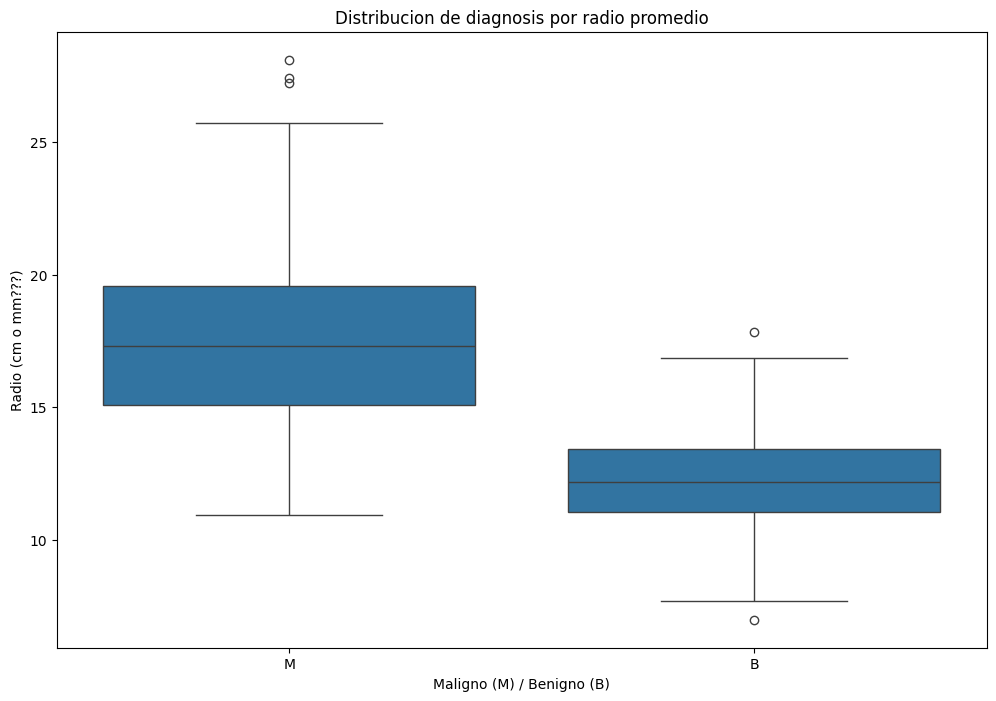

In [44]:
# Relacion entre diagnostico y radio promedio (mm o cm???????):
plt.figure(figsize=(12, 8))
sns.boxplot(x='diagnosis', y='radius_mean', data=cancer_data)
plt.title('Distribucion de diagnosis por radio promedio')
plt.xlabel('Maligno (M) / Benigno (B)')
plt.ylabel('Radio (cm o mm???)')
plt.show()

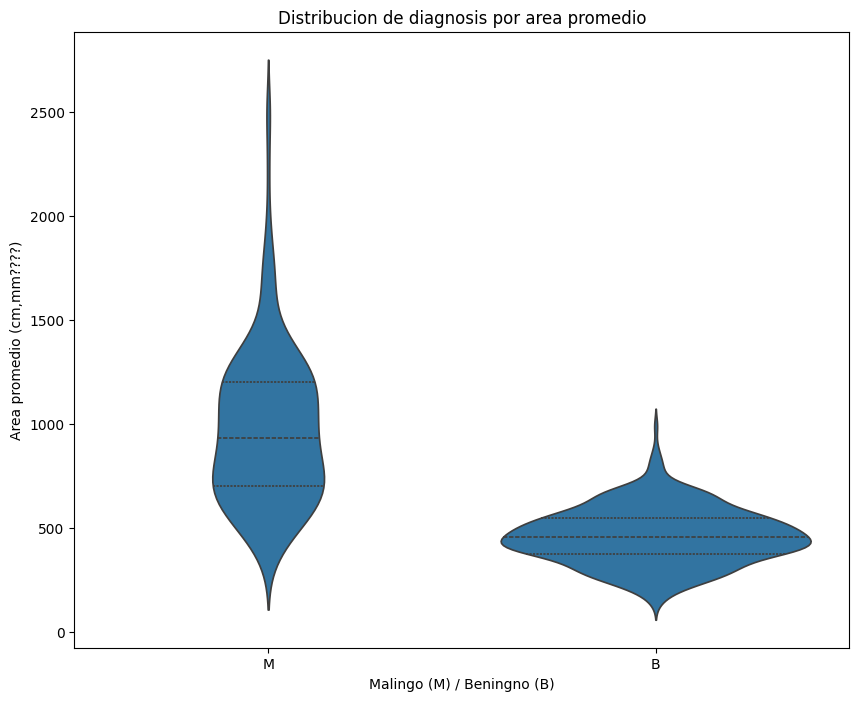

In [46]:
# Relacion entre diagnostico y area promedio (unidad????):
plt.figure(figsize=(10, 8))
sns.violinplot(x="diagnosis", y="area_mean", data=cancer_data, inner="quartile") #inner="quartile" dibuja los cuartiles dentro del violín.
plt.title("Distribucion de diagnosis por area promedio")
plt.xlabel("Malingo (M) / Beningno (B)")
plt.ylabel("Area promedio (cm,mm????)")
plt.show()

# Limpieza y preparacion de los datos